<a href="https://colab.research.google.com/github/IsaacMartindeDiego/IA/blob/master/Reconocimiento_de_d%C3%ADgitos_escritos_a_mano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/IsaacMartindeDiego/IA/blob/master/PDSH-cover-small.png?raw=1">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.02-Introducing-Scikit-Learn.ipynb#scrollTo=3WTV5etSTsCi*


# **Reconocimiento de dígitos escritos a mano**

Para demostrar los principios que fundamentan todo proyecto de Machine Learning, consideremos una parte del problema del reconocimiento óptico de caracteres: la identificación de dígitos escritos a mano. En la naturaleza, este problema implica tanto la localización como la identificación de caracteres en una imagen. Aquí tomaremos un atajo y utilizaremos el conjunto de dígitos preformateados de Scikit-Learn, que está incorporado en la biblioteca.


Crearemos un modelo siguiendo los siguientes pasos:

*   Adquirir y explorar los datos
*   Preparar los datos para entrenamiento
*   Crear un modelo sencillo de clasificación
*   Entrenar el modelo usando los datos de entrenamiento
*   Realizar predicciones con el modelo entrenado sobre los datos de test
*   Evaluar las predicciones realizadas
*   Criticar el modelo


# **Carga y visualización de los datos de los dígitos**

Em priner lugar, utilizaremos la interfaz de acceso a datos de Scikit-Learn y echaremos un vistazo a los datos:

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

Los datos de las imágenes son una matriz tridimensional: 1.797 muestras, cada una de ellas formada por una cuadrícula de 8 × 8 píxeles.
Visualicemos los cien primeros datos en la bases de datos:

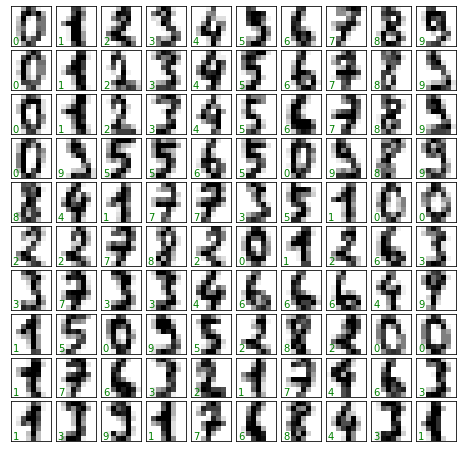

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')

Para trabajar con estos datos en la librería Scikit-Learn, necesitamos una representación bidimensional [n_muestras, n_características]. Podemos conseguirlo tratando cada píxel de la imagen como una característica: es decir, aplanando las matrices de píxeles para que tengamos una matriz de longitud 64 de valores de píxeles que representen cada dígito. Además, necesitamos el vector objetivo (variable respuesta), que da la etiqueta previamente determinada para cada dígito (la que deseamos aprender). Estas dos cantidades se incorporan al conjunto de datos de los dígitos bajo los atributos de datos y objetivo, respectivamente:

In [ ]:
X = digits.data
X.shape

(1797, 64)

In [ ]:
y = digits.target
y.shape

(1797,)

Aquí vemos que hay 1.797 muestras y 64 características.

# **Aprendizaje no supervisado: Reducción de la dimensionalidad**

Lo ideal sería visualizar nuestros puntos dentro del espacio de parámetros de 64 dimensiones, pero es difícil visualizar eficazmente los puntos en un espacio de tan alta dimensión. En su lugar, reduciremos las dimensiones a 2 (mucho más sencillo!!), utilizando un método no supervisado. En este caso, utilizaremos un algoritmo de aprendizaje llamado *Isomap*, y transformaremos los datos a dos dimensiones. Hay que notar que no usamos las etiquetas.

In [ ]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso.fit(digits.data)
data_projected = iso.transform(digits.data)
data_projected.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:304: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


(1797, 100)

Vemos que los datos proyectados son ahora bidimensionales.
Vamos a trazar estos datos para ver si podemos aprender algo de su estructura. Aquí usamos las etiquetas, únicamente, para colorear los puntos. Es decir, el método es *no supervisadpo*, pero usamos las etiquetas para comprobar que las dos dimensiones elegidas representan de manera correcta las diferencias entre los dígitos.

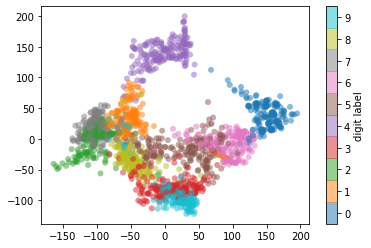

In [ ]:
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=digits.target,
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('tab10', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5);

Este gráfico nos da una buena intuición sobre la separación de los distintos números en el espacio mayor de 64 dimensiones. Por ejemplo, los ceros (en gris azulado) y los unos (en naranja) se solapan muy poco en el espacio de los parámetros. Intuitivamente, esto tiene sentido: un cero está vacío en el centro de la imagen, mientras que un uno suele tener tinta en el centro. Por otro lado, parece haber un espectro más o menos continuo entre los unos y los cuatros: podemos entenderlo si nos damos cuenta de que algunas personas dibujan los unos con "sombreros", lo que hace que se parezcan a los cuatros.

En general, sin embargo, los diferentes grupos parecen estar bastante bien separados en el espacio de los parámetros: esto nos dice que incluso un algoritmo de clasificación supervisada muy sencillo debería funcionar adecuadamente con estos datos. Vamos a probarlo.

# **Clasificación de los dígitos**

Vamos a aplicar un algoritmo de clasificación a los dígitos. Al igual que con los datos del Iris, dividiremos los datos en un conjunto de entrenamiento y otro de prueba, y ajustaremos un modelo Gaussian Naive Bayes.

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

Ahora que hemos predicho nuestro modelo, podemos medir su precisión comparando los valores reales del conjunto de pruebas con las predicciones:

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.8333333333333334

Incluso con este modelo extremadamente simple, encontramos una precisión de alrededor del 80% en la clasificación de los dígitos. Sin embargo, este número no nos dice en qué nos hemos equivocado; una buena forma de hacerlo es utilizar la matriz de confusión, que podemos calcular con Scikit-Learn y representar con Seaborn:

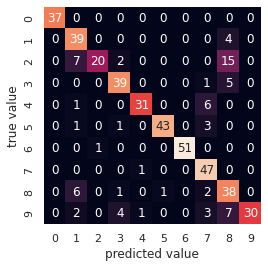

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

mat = confusion_matrix(ytest, y_model)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

Esto nos muestra dónde suelen estar los puntos mal etiquetados: por ejemplo, un gran número de dos están mal clasificados como unos u ochos. Otra forma de intuir las características del modelo es trazar de nuevo las entradas con sus etiquetas previstas. Utilizaremos el color verde para las etiquetas correctas y el rojo para las incorrectas:

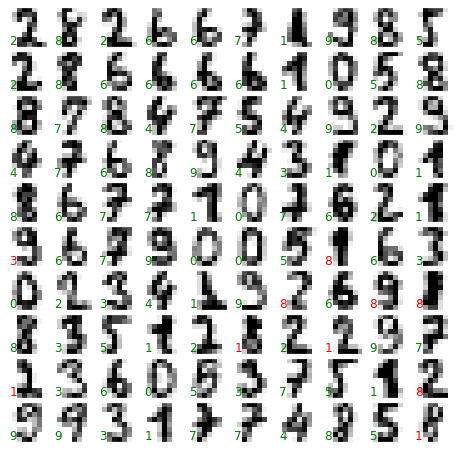

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 8, 8)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(y_model[i]),
            transform=ax.transAxes,
            color='green' if (ytest[i] == y_model[i]) else 'red')

Examinando este subconjunto de datos, podemos obtener información sobre los puntos en los que el algoritmo podría no estar funcionando de forma óptima. Para ir más allá de nuestra tasa de clasificación del 80%, podríamos pasar a un algoritmo más sofisticado, como las Máquinas de Vectores Soporte, los Bosques Aleatorios u otro enfoque de clasificación.

Examinando este subconjunto de datos, podemos obtener información sobre los puntos en los que el algoritmo podría no estar funcionando de forma óptima. Para ir más allá de nuestra tasa de clasificación del 80%, podríamos pasar a un algoritmo más sofisticado, como las máquinas de vectores de apoyo (véase En profundidad: Máquinas de vectores de apoyo), los bosques aleatorios (véase En profundidad: Árboles de decisión y bosques aleatorios) u otro enfoque de clasificación.



---



**DSLAB- Isaac Martín de Diego - 2022**








